# preprocessing

In [1]:
import numpy as np
import h5py
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = h5py.File("datasets/train_catvnoncat.h5","r")
test = h5py.File("datasets/test_catvnoncat.h5","r")
print(train.keys())

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [3]:
images_train = np.array(train["train_set_x"][:])
labels_train = np.array(train["train_set_y"][:]).reshape(1,-1)
images_test = np.array(test["test_set_x"][:])
labels_test = np.array(test["test_set_y"][:]).reshape(1,-1)

In [4]:
print(f" shape images_train : {images_train.shape} \n shape labels_train : {labels_train.shape} \n shape images_test : {images_test.shape}\n shape labels_test : {labels_test.shape}")

 shape images_train : (209, 64, 64, 3) 
 shape labels_train : (1, 209) 
 shape images_test : (50, 64, 64, 3)
 shape labels_test : (1, 50)


In [5]:
images_train_m = images_train.T.reshape(images_train.shape[1]*images_train.shape[2]*images_train.shape[3],-1)
images_test_m = images_test.T.reshape(images_test.shape[1]*images_test.shape[2]*images_test.shape[3],-1)

In [6]:
print(f" shape images_train_m : {images_train_m.shape} \n shape labels_train_m : {images_test_m.shape}")

 shape images_train_m : (12288, 209) 
 shape labels_train_m : (12288, 50)


In [7]:
images_train_sm = (images_train_m/255.).astype("float32")
images_test_sm = (images_test_m/255.).astype("float32")

# modelling

In [56]:
def sigmoid(x , derivative=False):
  x = np.array(x,dtype = np.float128)
  if not derivative:
    A = (1/(1+np.exp(-x)))
    assert(A.shape == x.shape)
    return A
  else :
    s = sigmoid(x)
    dA = (s*(1-s))
    assert(dA.shape == x.shape )
    return dA

In [9]:
def tanh(x,derivative=False):
  x = np.array(x)
  if not derivative:
    A = np.tanh(x)
    assert(A.shape == x.shape)
    return A
  else:
    dA = (1-np.power((np.tanh(x)),2))
    assert(dA.shape == x.shape )
    return dA

In [10]:
def relu(x,derivative=False):
  x = np.array(x)
  if not derivative:
    x[x<=0] = 0
    return x
  else:
    x[x>0] = 1
    x[x<=0] = 0
    return x

In [11]:
def leaky_relu(x , derivative=False):
  x = np.array(x)
  if not derivative:
    x[x<=0] = 0.01*x[x<=0]
    return x
  else :
    x[x > 0] = 1
    x[x<=0] = 0.01
    return x

In [12]:
def propagate(X,W1,b1,W2,b2,Y,activation1,activation2):
  m = X.shape[1]
  Z1 = np.dot(W1,X) + b1
  A1 = activation1(Z1)
  Z2 = np.dot(W2,A1) + b2
  A2 = activation2(Z2)
  cost = np.sum(-Y*np.log(A2)-(1-Y)*np.log(1-A2))/m
  #dA2 = -(Y/A2)-((1-Y)/(1-A2))
  dA2 = -(np.divide(Y,A2)-np.divide(1-Y,1-A2))
  dZ2 = dA2 * activation2(Z2,True)
  dW2 = np.dot(dZ2,A1.T)/m
  db2 = np.sum(dZ2,axis=1,keepdims=True)/m
  dA1 = np.dot(W2.T,dZ2)
  dZ1 = dA1 * activation1(Z1,True)
  dW1 = np.dot(dZ1,X.T) /m
  db1 = np.sum(dZ1,axis=1,keepdims=True)/m
  grad = {
      "db1":db1,
      "db2":db2,
      "dW1":dW1,
      "dW2":dW2
  }
  return grad , cost

In [13]:
def first_random_initialize(n1,n2):
  W1 = np.random.randn(n1,12288) / np.sqrt(12288)
  W2 = np.random.randn(n2,n1) / np.sqrt(n1)
  b1 = np.zeros((n1,1))
  b2 = np.zeros((n2,1))
  return W1,b1,W2,b2

In [14]:
class model:
    object_number = 0
    def __init__(self,name,act1,act2):
        model.object_number += 1
        self.name = name
        # self.W1
        # self.W2
        # self.b1
        # self.b2
        self.activation1 = act1
        self.activation2 = act2
        self.n1 = 3
        self.n2 = 1
        self.n0 = 12288
        self.accuracy_value = None
        self.W1 , self.b1 ,self.W2,self.b2 = first_random_initialize(self.n1,self.n2)
    def predict(self,X,prob=False):
        Z1 = np.dot(self.W1,X) + self.b1
        A1 = self.activation1(Z1)
        Z2 = np.dot(self.W2,A1) + self.b2
        A2 = self.activation2(Z2)
        if prob:
            return A2
        out = (A2>=0.5) * 1
        return out
    def accuracy(self,X,Y):
        y_hat = self.predict(X)
        correct = np.sum(y_hat == Y)
        return (correct / Y.shape[1])*100
    def train(self,X,Y,epochs,learning_rate,X_t,Y_t):
        alpha = learning_rate
        costs=[]
        accuracies_train = []
        accuracies_test = []
        for i in range(epochs):
            grad , cost = propagate(X,self.W1,self.b1,self.W2,self.b2,Y,self.activation1,self.activation2)
            costs.append(cost)
            self.W1 , self.b1 ,self.W2,self.b2 = self.W1-alpha*grad['dW1'] , self.b1-alpha*grad['db1'] ,self.W2-alpha*grad['dW2'],self.b2-alpha*grad['db2']
            accuracy_train = self.accuracy(X,Y)
            accuracy_test = self.accuracy(X_t,Y_t)
            accuracies_train.append(accuracy_train)
            accuracies_test.append(accuracy_test)
            if i % 100 == 0:
                print(f" iteration : {i}\n cost : {cost}\n train accuracy : {accuracy_train}\n test accuracy : {accuracy_test}\n *************************** ")
        return costs,accuracies_train,accuracies_test

In [15]:
model_1 = model("model_1_sigmoid",sigmoid,sigmoid)

In [20]:
costs , acc_tr , acc_te = model_1.train(images_train_sm,labels_train,2500,0.0075,images_test_sm,labels_test)

 iteration : 0
 cost : 0.4985493913288666
 train accuracy : 65.55023923444976
 test accuracy : 36.0
 *************************** 
 iteration : 100
 cost : 0.4891771087899022
 train accuracy : 65.55023923444976
 test accuracy : 40.0
 *************************** 
 iteration : 200
 cost : 0.47982622857964935
 train accuracy : 68.42105263157895
 test accuracy : 42.0
 *************************** 
 iteration : 300
 cost : 0.4704993385066043
 train accuracy : 69.85645933014354
 test accuracy : 44.0
 *************************** 
 iteration : 400
 cost : 0.4611997919755105
 train accuracy : 70.33492822966507
 test accuracy : 48.0
 *************************** 
 iteration : 500
 cost : 0.45193890291880384
 train accuracy : 70.81339712918661
 test accuracy : 50.0
 *************************** 
 iteration : 600
 cost : 0.4427449756567909
 train accuracy : 72.24880382775119
 test accuracy : 57.99999999999999
 *************************** 
 iteration : 700
 cost : 0.4336603928649937
 train accuracy : 7

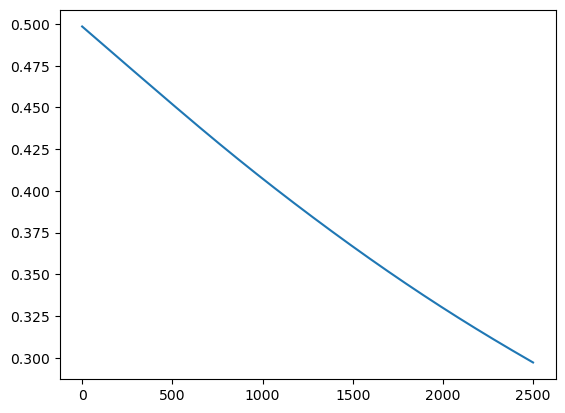

In [21]:
plt.plot(costs)

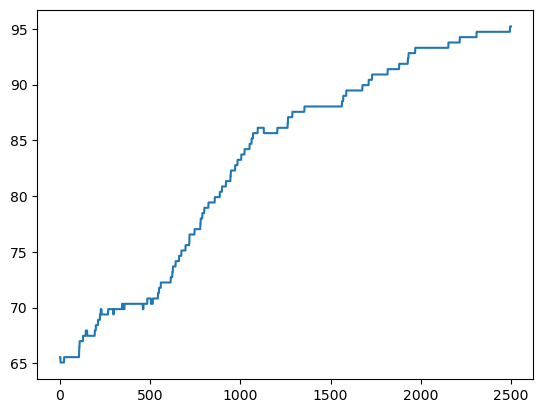

In [22]:
plt.plot(acc_tr)

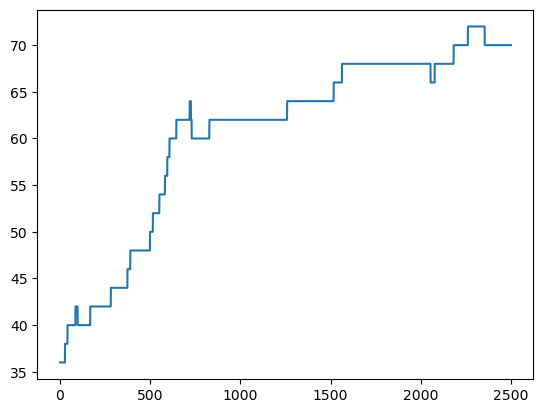

In [23]:
plt.plot(acc_te)

In [24]:
model_2 = model("model_2_tanh",tanh,sigmoid)

In [25]:
costs , acc_tr , acc_te = model_2.train(images_train_sm,labels_train , 2500,0.0075,images_test_sm,labels_test)

 iteration : 0
 cost : 0.6945192393905671
 train accuracy : 65.07177033492823
 test accuracy : 34.0
 *************************** 
 iteration : 100
 cost : 0.579812367543318
 train accuracy : 80.38277511961722
 test accuracy : 54.0
 *************************** 
 iteration : 200
 cost : 0.49326601509182744
 train accuracy : 84.21052631578947
 test accuracy : 72.0
 *************************** 
 iteration : 300
 cost : 0.44458406919221205
 train accuracy : 85.16746411483254
 test accuracy : 74.0
 *************************** 
 iteration : 400
 cost : 0.40168371055548835
 train accuracy : 87.5598086124402
 test accuracy : 74.0
 *************************** 
 iteration : 500
 cost : 0.3599649329658894
 train accuracy : 88.51674641148325
 test accuracy : 74.0
 *************************** 
 iteration : 600
 cost : 0.31262561912326636
 train accuracy : 90.9090909090909
 test accuracy : 70.0
 *************************** 
 iteration : 700
 cost : 0.2594194355610118
 train accuracy : 92.344497607655

Text(0.5, 1.0, 'test_accuracy')

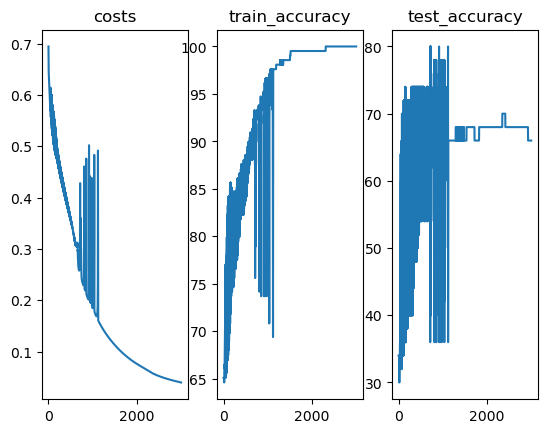

In [28]:
#costs , acc_tr , acc_te
plt.Figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(costs)
plt.title("costs")
plt.subplot(1,3,2)
plt.plot(acc_tr)
plt.title("train_accuracy")
plt.subplot(1,3,3)
plt.plot(acc_te)
plt.title("test_accuracy")

In [29]:
model_3 = model("model_3_relu",relu,sigmoid)

In [31]:
costs , acc_tr , acc_te = model_3.train(images_train_sm,labels_train , 2500,0.0075,images_test_sm,labels_test)

 iteration : 0
 cost : 0.07151500498729552
 train accuracy : 97.60765550239235
 test accuracy : 72.0
 *************************** 
 iteration : 100
 cost : 0.06328701993239642
 train accuracy : 98.08612440191388
 test accuracy : 72.0
 *************************** 
 iteration : 200
 cost : 0.05612176049226714
 train accuracy : 99.04306220095694
 test accuracy : 74.0
 *************************** 
 iteration : 300
 cost : 0.049755723339635245
 train accuracy : 100.0
 test accuracy : 72.0
 *************************** 
 iteration : 400
 cost : 0.044024224292914686
 train accuracy : 100.0
 test accuracy : 72.0
 *************************** 
 iteration : 500
 cost : 0.03909361860360223
 train accuracy : 100.0
 test accuracy : 72.0
 *************************** 
 iteration : 600
 cost : 0.034980945872679275
 train accuracy : 100.0
 test accuracy : 72.0
 *************************** 
 iteration : 700
 cost : 0.0314548529868659
 train accuracy : 100.0
 test accuracy : 70.0
 *************************

Text(0.5, 1.0, 'test_accuracy')

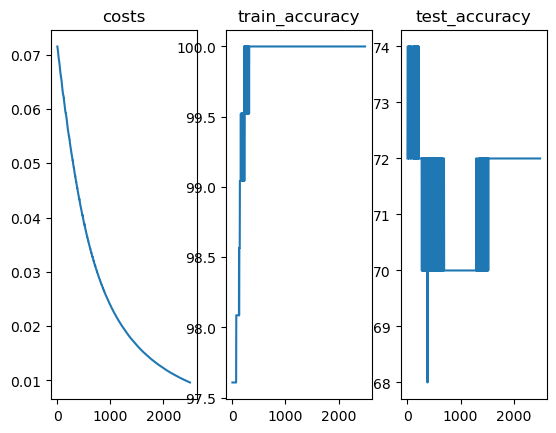

In [32]:
plt.Figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(costs)
plt.title("costs")
plt.subplot(1,3,2)
plt.plot(acc_tr)
plt.title("train_accuracy")
plt.subplot(1,3,3)
plt.plot(acc_te)
plt.title("test_accuracy")

In [37]:
model_4 = model("model_3_relu",leaky_relu,sigmoid)

In [38]:
costs , acc_tr , acc_te = model_4.train(images_train_sm,labels_train , 2500,0.0075,images_test_sm,labels_test)

 iteration : 0
 cost : 0.6813074818412457
 train accuracy : 65.55023923444976
 test accuracy : 34.0
 *************************** 
 iteration : 100
 cost : 0.5249161191458773
 train accuracy : 73.20574162679426
 test accuracy : 44.0
 *************************** 
 iteration : 200
 cost : 0.4800428389175607
 train accuracy : 83.73205741626795
 test accuracy : 70.0
 *************************** 
 iteration : 300
 cost : 0.4457496371592839
 train accuracy : 85.64593301435407
 test accuracy : 82.0
 *************************** 
 iteration : 400
 cost : 0.4035493429991567
 train accuracy : 88.51674641148325
 test accuracy : 84.0
 *************************** 
 iteration : 500
 cost : 0.35797191786924665
 train accuracy : 89.47368421052632
 test accuracy : 82.0
 *************************** 
 iteration : 600
 cost : 0.3143136877653665
 train accuracy : 91.86602870813397
 test accuracy : 82.0
 *************************** 
 iteration : 700
 cost : 0.2752892634893948
 train accuracy : 93.779904306220

Text(0.5, 1.0, 'test_accuracy')

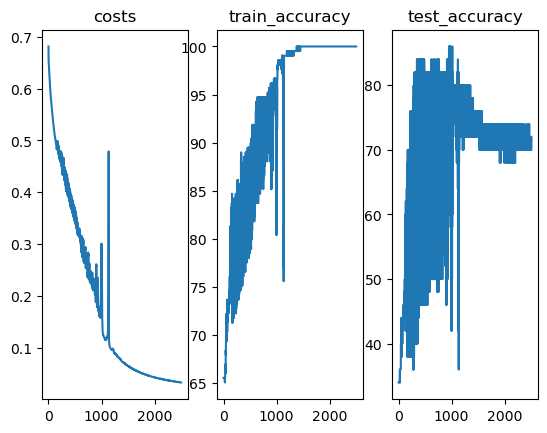

In [39]:
plt.Figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(costs)
plt.title("costs")
plt.subplot(1,3,2)
plt.plot(acc_tr)
plt.title("train_accuracy")
plt.subplot(1,3,3)
plt.plot(acc_te)
plt.title("test_accuracy")

i dont now why but this show a very bad result from shalow neural net work . maybe i handle it very bad or maybe this is the real reasult . i try to use keras next time for check that is my implemetation is good one or not

after implement code with tensorflow we find out this manual code has problem :
- some of formula in backpropagation isn't working beacuse they dont suppurt matrix form corectly
- these formula doesnt handle devide by zero 

- 2/15/2024 10:20 
- we complete and corect this implemetation and it has a very good result so
- the above text isnt wright from this time 

# evaluating

## first cat 

(-0.5, 63.5, 63.5, -0.5)

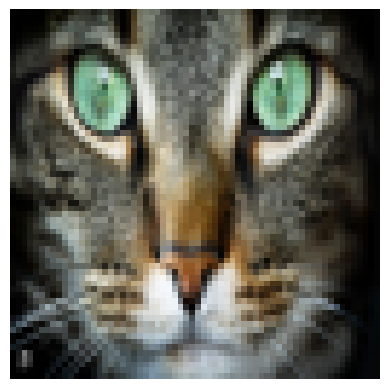

In [41]:
png = Image.open("images_/cat_2.png")
png.load()
# convert an RGBA to RGB 
background = Image.new("RGB", png.size, (255, 255, 255))
background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
background.save('foo.jpg', 'JPEG', quality=80)
image = background.resize((64,64))
array = np.array(image)#.T.reshape(-1,1)
plt.imshow(array)
plt.axis("off")


In [44]:
input_array = array.T.reshape(12288,1)

In [45]:
model_1.predict(input_array,True)

array([[0.6979229]])

In [46]:
model_2.predict(input_array,True)


array([[0.01037731]])

In [57]:
model_3.predict(input_array,True)


array([[1.]])

In [48]:
model_4.predict(input_array,True)


array([[1.36659777e-96]])

- as you can see model1 and model3 work better than other

## second cat 

(-0.5, 63.5, 63.5, -0.5)

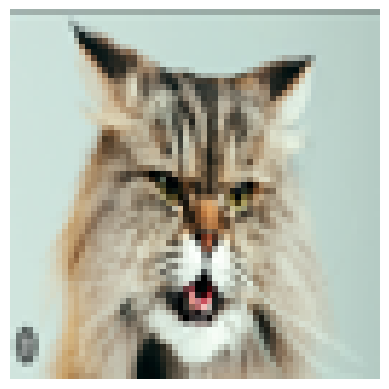

In [50]:
png = Image.open("images_/cat_5.png")
png.load()
# convert an RGBA to RGB 
background = Image.new("RGB", png.size, (255, 255, 255))
background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
background.save('foo.jpg', 'JPEG', quality=80)
image = background.resize((64,64))
array = np.array(image)#.T.reshape(-1,1)
plt.imshow(array)
plt.axis("off")

In [51]:
input_array = array.T.reshape(12288,1)

In [59]:
model_1.predict(input_array,True)

C:\Users\ARMA\AppData\Local\Temp\ipykernel_7188\2116219806.py:4: RuntimeWarning: overflow encountered in exp
  A = (1/(1+np.exp(-x)))


array([[0.6979229]])

i try to handele this warning with np.float128 and this work for another one but this isnt work for above case . maybe later i come back and fix it 

In [53]:
model_2.predict(input_array,True)

array([[0.98944691]])

In [60]:
model_3.predict(input_array,True)

array([[1.]])

In [55]:
model_4.predict(input_array,True)

array([[5.65956286e-194]])

- in this part model_2 and model_3 work better 

i feel model 3 is a little suspicious and maybee i check it later 